In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

### Dataset Generation

In [43]:
def generate_dataset(dataset=1, num_samples=40):
    if dataset == 1:
        np.random.seed(45)
        x = np.random.uniform(-20, 20, num_samples)
        f_x = 100*x + 1
        eps = np.random.randn(num_samples)
        y = f_x + eps
        theta_star = torch.tensor([1.0, 100.0])
    else:
        np.random.seed(45)
        x = np.random.uniform(-1, 1, num_samples)
        f_x = 3*x + 4
        eps = np.random.randn(num_samples)
        y = f_x + eps
        theta_star = torch.tensor([4.0, 3.0])

    # Convert to torch tensors
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X = torch.stack([torch.ones_like(x), x], dim=1) 
    return X, y, theta_star

In [44]:
def mse_loss(X,y, theta):
    pred = X @ theta
    return 0.5 * torch.mean((y-pred)**2)

In [45]:
def comp_grad(X, y, theta):
    n = X.shape[0]
    grad = -(X.T @ (y- X @ theta))/n
    return grad

In [46]:
def fullgd(X, y, theta_star, lr=0.0001, eps=0.001, max_epoch=1000):
    theta = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0

    for epoch in range(max_epoch):
        loss = mse_loss(X,y,theta)
        losses.append(loss.item())
        path.append(theta.clone().numpy())

        grad = comp_grad(X,y,theta)
        theta -= lr*grad

        steps += 1

        if torch.norm(theta - theta_star) < eps:
            break
    
    return theta, losses, np.array(path), steps

In [47]:
def sgd(X, y, theta_star, lr=0.0001, eps=0.001, max_epoch=1000):
    theta = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0
    n = X.shape[0]

    for epoch in range(max_epoch):
        idx = torch.randperm(n)

        for i in idx:
            xi = X[i].unsqueeze(0)
            yi = y[i].unsqueeze(0)

            grad = comp_grad(xi, yi, theta)
            theta -= lr * grad

            path.append(theta.clone().numpy())
            steps += 1
            if torch.norm(theta - theta_star) < eps:
                losses.append(mse_loss(X, y, theta).item())
                return theta, losses, np.array(path), steps

        losses.append(mse_loss(X, y, theta).item())
    return theta, losses, np.array(path), steps

In [48]:
def run_experiments(num_trials=5):
    results = {}
    for dataset in [1, 2]:
        X, y, theta_star = generate_dataset(dataset)

        theta_gd, losses_gd, path_gd, steps_gd = fullgd(X, y, theta_star, lr=0.01)

        steps_sgd_list, paths_sgd, losses_sgd = [], [], []
        for trial in range(num_trials):
            torch.manual_seed(45 + trial)
            theta_sgd, losses_trial, path_trial, steps_trial = sgd(X, y, theta_star, lr=0.01)
            steps_sgd_list.append(steps_trial)
            paths_sgd.append(path_trial)
            losses_sgd.append(losses_trial)

        results[dataset] = {
            "theta_star": theta_star,
            "gd": (theta_gd, losses_gd, path_gd, steps_gd),
            "sgd": (theta_sgd, losses_sgd, paths_sgd, np.mean(steps_sgd_list))
        }
    return results

results = run_experiments()


Dataset 1
 Full-batch GD steps: 1000, final θ: [ 0.95056736 99.98412   ]
 SGD average steps: 27332.40, final θ (last trial): [  1.0005115 100.00057  ]


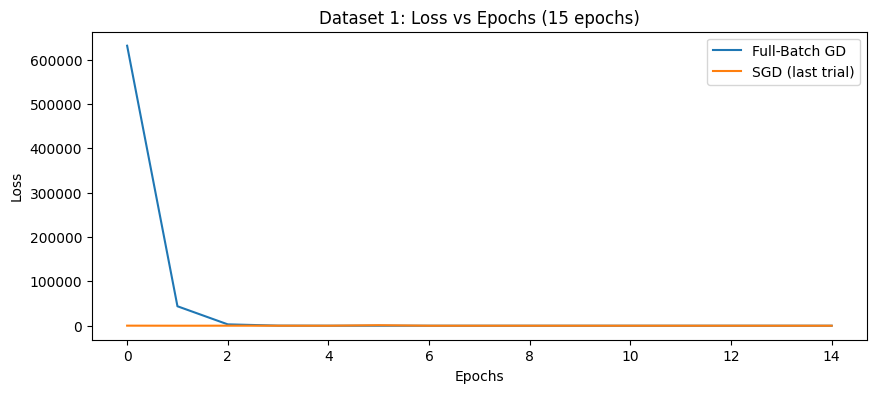

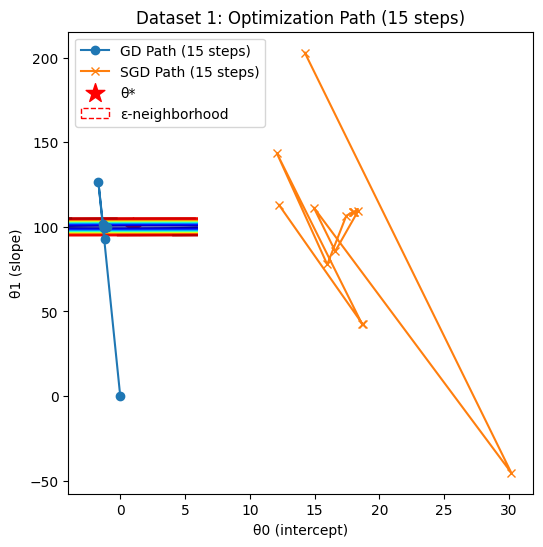


Dataset 2
 Full-batch GD steps: 1000, final θ: [3.9327366 2.5362704]
 SGD average steps: 40000.00, final θ (last trial): [3.9547558 2.677976 ]


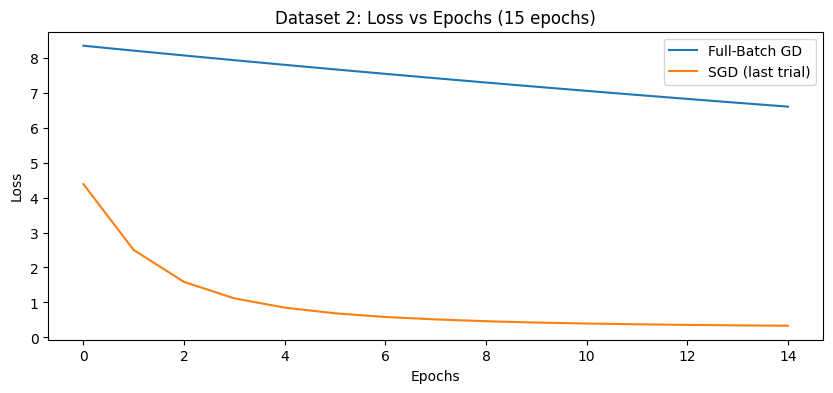

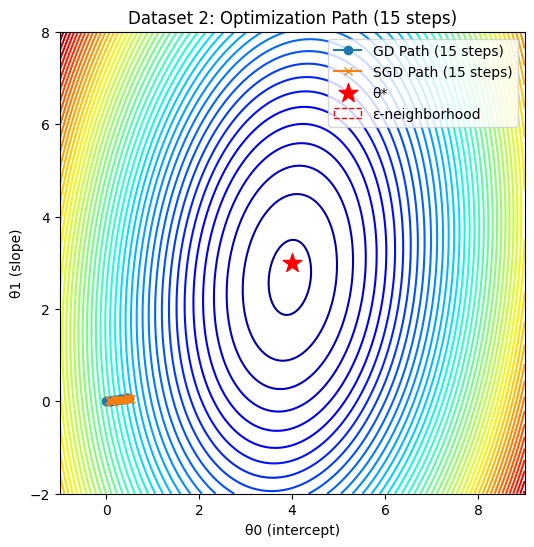

In [49]:
for dataset in [1, 2]:
    X, y, theta_star = generate_dataset(dataset)

    theta_gd, losses_gd, path_gd, steps_gd = results[dataset]["gd"]
    theta_sgd, losses_sgd, paths_sgd, steps_sgd_avg = results[dataset]["sgd"]

    print(f"\nDataset {dataset}")
    print(f" Full-batch GD steps: {steps_gd}, final θ: {theta_gd.numpy()}")
    print(f" SGD average steps: {steps_sgd_avg:.2f}, final θ (last trial): {theta_sgd.numpy()}")

    plt.figure(figsize=(10,4))
    plt.plot(losses_gd[:15], label="Full-Batch GD")
    plt.plot(losses_sgd[-1][:15], label="SGD (last trial)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Dataset {dataset}: Loss vs Epochs (15 epochs)")
    plt.legend()
    plt.show()

    t0 = np.linspace(theta_star[0].item()-5, theta_star[0].item()+5, 200)
    t1 = np.linspace(theta_star[1].item()-5, theta_star[1].item()+5, 200)
    T0, T1 = np.meshgrid(t0, t1)
    Z = np.zeros_like(T0)

    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            theta_temp = torch.tensor([T0[i,j], T1[i,j]], dtype=torch.float32)
            Z[i,j] = mse_loss(X, y, theta_temp).item()

    plt.figure(figsize=(6,6))
    plt.contour(T0, T1, Z, levels=50, cmap="jet")

    plt.plot(path_gd[:15,0], path_gd[:15,1], "o-", label="GD Path (15 steps)")
    plt.plot(paths_sgd[-1][:15,0], paths_sgd[-1][:15,1], "x-", label="SGD Path (15 steps)")

    plt.scatter(theta_star[0], theta_star[1], c="red", marker="*", s=200, label="θ*")
    circle = plt.Circle((theta_star[0], theta_star[1]), 0.001, color="red", fill=False, linestyle="--", label="ε-neighborhood")
    plt.gca().add_artist(circle)

    plt.xlabel("θ0 (intercept)")
    plt.ylabel("θ1 (slope)")
    plt.title(f"Dataset {dataset}: Optimization Path (15 steps)")
    plt.legend()
    plt.show()


In [ ]:
def momentum_gd(X, y, theta_star,lr=0.01,beta=0.9,eps=1e-3,max_epochs=1000):
    theta = torch.zeros(X.shape[1])
    v = torch.zeros_like(theta)
    losses, path, grads, velocities = [], [], [], []
    steps = 0

    for epoch in range(max_epochs):
        grad = comp_grad(X,y,theta)
        v = beta*v+lr*grad
        theta -= v

        step += 1
        losses.append(mse_loss(X, y, theta).item())
        path.append(theta.clone().numpy())
        grads.append(grad.clone().numpy())
        velocities.append(v.clone().numpy())

        if torch.norm(theta - theta_star) < eps:
            break

    return theta, losses, np.array(path), np.array(grads), np.array(velocities), steps